# Departamento de marketing - Test A/B

# Contexto
Eres analista en una gran tienda en línea. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos. 
Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

# Contenido

* [Objetivos](#objetivos)
* [Diccionario de Datos](#diccionario)
* [1 Inicialización](#inicio)
* [2 Parte 1. Priorizar hipótesis](#hipotheses)
* [3 Parte 2. Análisis de test A/B](#test)
	* [3.1 Ingresos Acumulados por Grupo](#acumulado_ingreso)
	* [3.2 Tamaño de Pedido Promedio Acumulado por Grupo](#acumulado_pedido)
	* [3.3 Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A](#dif_rel_pedidos)
	* [3.4 Tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día](#conversion_acum)
	* [3.5 Tasas de conversión diarias de los dos grupos](#conversion_diaria)
	* [3.6 Valores atípicos y aumentos: valores extremos](#atipicos)
		* [3.6.1 Gráfico de dispersión del número de pedidos por usuario](#scatter_orders)
		* [3.6.2 Gráfico de dispersión de los precios de los pedidos](#scatter_price)
	* [3.7 Significancia estadística de la diferencia en la conversión entre los grupos con los datos en bruto](#sig_esta_conversion)
	* [3.8 Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto](#sig_esta_pedidos)
	* [3.9 Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados](#conversion_filtrado)
	* [3.10 Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados](#pedidos_filtrado)
* [4 Resumen y Conclusión General](#end)


# Objetivos <a id='objetivos'></a>  

* Obtener una comprensión general de los datos.  
* Identificar tendencias y patrones importantes.  
* Preparar los datos para el análisis.   
* Analizar los resultados del test A/B.  

# Diccionario de Datos <a id='diccionario'></a>   

* DataFrame `hypotheses_us`:  
    * `Hypotheses`: breves descripciones de las hipótesis.  
    * `Reach`: alcance del usuario, en una escala del uno a diez.  
    * `Impact`: impacto en los usuarios, en una escala del uno al diez.  
    * `Confidence`: confianza en la hipótesis, en una escala del uno al diez.  
    * `Effort`: los recursos necesarios para probar una hipótesis, en una escala del uno al diez. Cuanto mayor sea el valor Effort, más recursos requiere la prueba.  
    
* DataFrame `orders_us`:  
    * `transactionId`: identificador de pedido.  
    * `visitorId`: identificador del usuario que realizó el pedido.  
    * `date`: fecha del pedido.  
    * `revenue`: ingresos del pedido.  
    * `group`: el grupo del test A/B al que pertenece el usuario.  
* DataFrame `visits_us`:  
    * `date`: la fecha.  
    * `group`: grupo del test A/B.  
    * `visits`: el número de visitas en la fecha especificada para el grupo de test A/B especificado.  

## Inicialización <a id='inicio'></a>

In [1]:
# se cargan todas las librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

In [2]:
# se descargan los datos completos con los tipos de datos correctos

hypotheses_us = pd.read_csv('files/datasets/hypotheses_us.csv', sep= ';')
orders_us = pd.read_csv('files/datasets/orders_us.csv', parse_dates= ['date'])
visits_us = pd.read_csv('files/datasets/visits_us.csv', parse_dates= ['date'])

In [3]:
# se muestra la información de cada DataFrame
hypotheses_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
orders_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [5]:
visits_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [6]:
# se cambian a minúsculas los nombres de las columnas del DataFrame 'hypotheses_us'
# se crea una lista vacia para almcenar los nombres modificados
column_names = []
# se itera sobre cada nombre de columna con un bucle for
for name in hypotheses_us.columns:
    names_lower = name.lower()
    column_names.append(names_lower)

In [7]:
# se asignan los nuevos nombres de columna
hypotheses_us.columns = column_names

In [8]:
# se modifica el nombre las columnas 'transactionId' y 'visitorId' del DataFrame orders_us
orders_us = orders_us.rename(columns= {'transactionId':'transaction_id', 'visitorId': 'visitor_id'})

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
Se tienen el tipo de datos correctos en los DataFrames y no hay valores nulos, por tanto, se procede con el análisis.
    
</span>
    
</div>

## Parte 1. Priorizar hipótesis  <a id='hipotheses'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**ICE y RICE:**  
Impacto, confianza, esfuerzo (ICE) es una de las formas más populares de priorizar
problemas: `ICE score = (Impact x Confidence) / Effort`
    
También existe una forma modificada, RICE: `RICE score = (Reach x Impact x Confidence) / Effort`.
    
A partir del DataFrame `hypotheses_us` se calculará ICE y RICE, para priorizar hipótesis. Se ordenarán en orden descendente de prioridad.
    
    
</span>
    
</div>

In [9]:
# se imprime el DataFrame 'hypotheses_us'
hypotheses_us

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


In [10]:
# se crea una columna para almacenar el valor de ICE
hypotheses_us['ICE'] = (hypotheses_us['impact'] * hypotheses_us['confidence']) / hypotheses_us['effort']

In [11]:
# se ordenan en orden descendente de prioridad.
hypotheses_us[['hypothesis', 'ICE']].sort_values(by= 'ICE', ascending= False)

,hypothesis,ICE
8,Launch a promotion that gives users discounts ...,16.200000
0,Add two new channels for attracting traffic. T...,13.333333
7,Add a subscription form to all the main pages....,11.200000
6,Show banners with current offers and sales on ...,8.000000
2,Add product recommendation blocks to the store...,7.000000
1,Launch your own delivery service. This will sh...,2.000000
5,Add a customer review page. This will increase...,1.333333
3,Change the category structure. This will incre...,1.125000
4,Change the background color on the main page. ...,1.000000


In [12]:
print('Tres hipótesis más prometedoras con ICE:')
print(hypotheses_us.iloc[8][0])
print(hypotheses_us.iloc[0][0])
print(hypotheses_us.iloc[7][0])

Tres hipótesis más prometedoras con ICE:
Launch a promotion that gives users discounts on their birthdays
Add two new channels for attracting traffic. This will bring 30% more users
Add a subscription form to all the main pages. This will help you compile a mailing list


In [13]:
# se crea una columna para almacenar el valor de RICE
hypotheses_us['RICE'] = (hypotheses_us['reach'] * hypotheses_us['impact'] * hypotheses_us['confidence']) / hypotheses_us['effort']

In [14]:
# se ordenan en orden descendente de prioridad.
hypotheses_us[['hypothesis', 'RICE']].sort_values(by= 'RICE', ascending= False)

,hypothesis,RICE
7,Add a subscription form to all the main pages....,112.0
2,Add product recommendation blocks to the store...,56.0
0,Add two new channels for attracting traffic. T...,40.0
6,Show banners with current offers and sales on ...,40.0
8,Launch a promotion that gives users discounts ...,16.2
3,Change the category structure. This will incre...,9.0
1,Launch your own delivery service. This will sh...,4.0
5,Add a customer review page. This will increase...,4.0
4,Change the background color on the main page. ...,3.0


In [15]:
print('Tres hipótesis más prometedoras con RICE:')
print(hypotheses_us.iloc[7][0])
print(hypotheses_us.iloc[2][0])
print(hypotheses_us.iloc[0][0])

Tres hipótesis más prometedoras con RICE:
Add a subscription form to all the main pages. This will help you compile a mailing list
Add product recommendation blocks to the store's site. This will increase conversion and average purchase size
Add two new channels for attracting traffic. This will bring 30% more users


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
En el caso del framework **ICE** las 3 hipótesis más prometedoras son las que tienen los índices 8, 0 y 7, mientras que el framework **RICE** las 3 hipótesis más prometedoras son las que tienen los índices 7, 2 y 0. Las hipótesis 8 y 0 tiene valores muy altos de impacto y confianza tienen una calificación alta, sin embargo, el alcance que tienen es muy bajo su puntaje. Lo anterior significa que se alcanzan a muy pocos usuarios y usuarias, esa una de las principales diferencias entre **ICE** y **RICE**, este último toma en cuenta el alcance de las hipótesis, es decir, a cuántos usuarios/as se alcanzan. Mientras que, en el framework **RICE** la hipótesis 7 ocupa el primer lugar, ya que su puntaje del alcance es mayor que las hipótesis 8 y 0. 
    
    
</span>
    
</div>

## Parte 2. Análisis de test A/B <a id='test'></a>

###  Ingresos Acumulados por Grupo <a id='acumulado_ingreso'></a>

In [44]:
# para verificar si existen usuarios que estén tanto en el grupo A como en el grupo B se emplea set()
# después se encuentra la instersección de ambos conjuntos con intersection()

# se obtienen conjuntos únicos de visitor_id para cada grupo
visitors_group_A = set(orders_us[orders_us['group'] == 'A']['visitor_id'])
visitors_group_B = set(orders_us[orders_us['group'] == 'B']['visitor_id'])

# Encuentra la intersección de los conjuntos (usuarios presentes en ambos grupos)
common_visitors = visitors_group_A.intersection(visitors_group_B)

# Se muestra la cantidad y los visitor_id que están en ambos grupos
if not common_visitors:
    print("No hay usuarios que estén en ambos grupos A y B.")
else:
    print(f"{len(common_visitors)} usuarios encontrados en ambos grupos:")
    print(common_visitors)

58 usuarios encontrados en ambos grupos:
{3957174400, 3984495233, 2780786433, 1294878855, 1648269707, 1614305549, 4120364173, 232979603, 199603092, 4266935830, 2712142231, 2587333274, 2716752286, 3891541246, 1668030113, 2654030115, 3234906277, 1230306981, 1404934699, 3803269165, 2949041841, 237748145, 457167155, 2927087541, 1738359350, 3062433592, 3656415546, 818047933, 393266494, 963407295, 471551937, 2579882178, 3202540741, 2686716486, 1333886533, 2044997962, 3941795274, 1801183820, 2378935119, 4256040402, 4069496402, 3766097110, 8300375, 351125977, 1602967004, 276558944, 2038680547, 3951559397, 3963646447, 4186807279, 3717692402, 1959144690, 2458001652, 2600415354, 2954449915, 1316129916, 477780734, 3972127743}


In [55]:
# ahora se filtra el DataFrame 'orders_us' en donde no se tengan estos usuarios
orders_us = orders_us[~orders_us['visitor_id'].isin(list(common_visitors))]
orders_us.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B
5,182168103,935554773,2019-08-15,35.0,B


In [56]:
# se crea una matriz con valores únicos de parejas fecha-grupo con el método drop_duplicates()
datesGroups = orders_us[['date', 'group']].drop_duplicates()
datesGroups.head()

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [58]:
# se declara la variable ordersAggregated para almacenar: 
# la fecha
# el grupo del test A/B
# el número de pedidos distintos para el grupo de prueba hasta la fecha especificada incluida
# el número de usuarios distintos en el grupo de prueba que realizan al menos un pedido hasta la fecha especificada incluida
# ingresos totales de pedidos en el grupo de prueba hasta la fecha especificada incluida
ordersAggregated = datesGroups.apply(lambda x: orders_us[np.logical_and(orders_us['date'] <= x['date'], orders_us['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,2266.6
66,2019-08-01,B,17,17,967.2
175,2019-08-02,A,42,36,3734.9
173,2019-08-02,B,40,39,3535.3
291,2019-08-03,A,66,60,5550.1


In [59]:
# se hace algo parecido para obtener los datos diarios acumulados agregados sobre los visitantes
# s declara la variable visitorsAggregated para almacenar:
# la fecha
# el grupo del test A/B
# el número de pedidos distintos para el grupo de prueba hasta la fecha especificada incluida
visitorsAggregated = datesGroups.apply(lambda x: visits_us[np.logical_and(visits_us['date'] <= x['date'], visits_us['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visits
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [60]:
# se fusionan los dos DataFrames 'ordersAggregated' y 'visitorsAggregated' en uno por las columnas 'date' y 'group'
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
# se dan a sus columnas nombres descriptivos
# se asignan los nombres ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors'] a las columnas en cumulativeData
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
      
Se declaran las variables `cumulativeRevenueA` y `cumulativeRevenueB`, donde se almacenan los datos sobre fechas, ingresos y número de pedidos para los grupos A y B 
    
    
</span>
    
</div>

In [61]:
# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueA.head()

,date,revenue,orders
0,2019-08-01,2266.6,23
2,2019-08-02,3734.9,42
4,2019-08-03,5550.1,66
6,2019-08-04,6225.6,77
8,2019-08-05,7623.6,99


In [62]:
# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,967.2,17
3,2019-08-02,3535.3,40
5,2019-08-03,4606.9,54
7,2019-08-04,6138.5,68
9,2019-08-05,7587.8,89


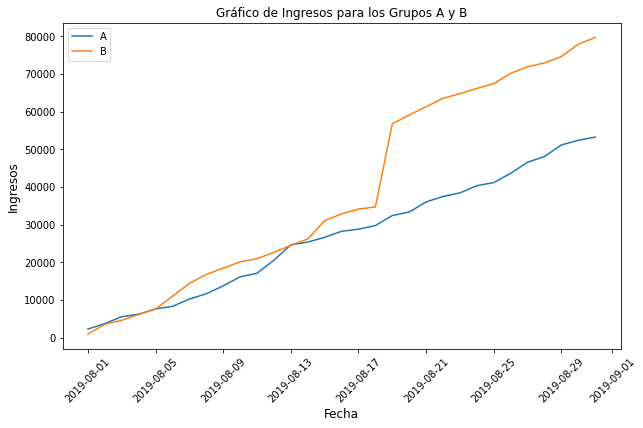

In [63]:
# ajustar los valores de ancho y alto del gráfico
plt.figure(figsize=(10, 6))
# se traza el gráfico de ingresos del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# se traza el gráfico de ingresos del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
# se rotan las fechas en el eje x a 45 grados
plt.xticks(rotation=45)

# se asigna un nombre
plt.title('Gráfico de Ingresos para los Grupos A y B')
# se nombran los ejes
plt.xlabel('Fecha', fontsize= 12)
plt.ylabel('Ingresos', fontsize= 12)

# se muestra el gráfico
plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
Los ingresos aumentan durante toda la prueba, sin embargo, el grupo B lo hace con mayor rapidez que el grupo A. Después del 17-08-2019 los ingresos del grupo B aumentan drásticamente, a diferencia del grupo A que lo hace con menor velocidad. Lo anterior se puede deber a un aumento en el número de los pedidos o pedidos que son muy costosos.  
    
</span>
    
</div>

### Tamaño de Pedido Promedio Acumulado por Grupo. <a id='acumulado_pedido'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Ahora se traza el tamaño promedio de compra por grupo. Se dividen los ingresos acumulados entre el número acumulado de pedidos. 
    
</span>
    
</div>

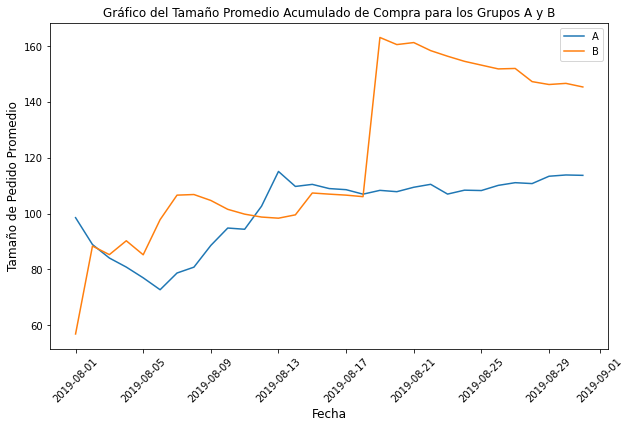

In [64]:
# se ajustan los valores de ancho y alto del gráfico
plt.figure(figsize=(10, 6))

# se traza el gráfico del tamaño promedio de compra por el grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
# se traza el gráfico del tamaño promedio de compra por el grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')

plt.legend()

# se rotan las fechas en el eje x a 45 grados
plt.xticks(rotation=45)

# se asigna un nombre
plt.title('Gráfico del Tamaño Promedio Acumulado de Compra para los Grupos A y B')
# se nombran los ejes
plt.xlabel('Fecha', fontsize= 12)
plt.ylabel('Tamaño de Pedido Promedio', fontsize= 12)

# se muestra el gráfico
plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
El tamaño promedio de compra del grupo B aumenta mucho depués del 17-08-2019, se aprecia un pico y después disminuye y se estabiliza al final. Mientras que, el grupo A también aumenta pero en menor medida, también al final parece estabilizarse.
    
</span>
    
</div>

### Diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. <a id='dif_rel_pedidos'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Se traza un gráfico de diferencia relativa para los tamaños promedio de compra para el grupo B en comparación con el grupo A.  
    
</span>
    
</div>

In [65]:
# se reunen los datos en un sólo DataFrame de 'cumulativeRevenueA' y 'cumulativeRevenueB' con el método merge() 
# asi todo el DataFrame resultante contenga las columnas ['date', 'revenueA', 'revenueB', 'ordersA', 'ordersB']
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


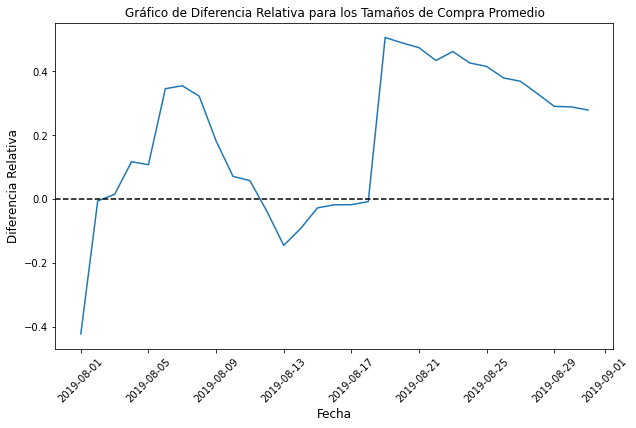

In [66]:
# se ajustan los valores de ancho y alto del gráfico
plt.figure(figsize=(10, 6))

# trazar un gráfico de diferencia relativa para los tamaños de compra promedio
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# agregar el eje X
plt.axhline(y=0, color='black', linestyle='--')

# se rotan las fechas en el eje x a 45 grados
plt.xticks(rotation=45)

# se asigna un nombre
plt.title('Gráfico de Diferencia Relativa para los Tamaños de Compra Promedio')
# se nombran los ejes
plt.xlabel('Fecha', fontsize= 12)
plt.ylabel('Diferencia Relativa', fontsize= 12)

plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
En algunos puntos o fechas la diferencia entre los segmentos aumenta mucho y después disminuye, se puede deber a compras muy grandes o valores atípicos. Y sólo hay un valor que es menor que 0, después la diferencia aumenta y se vuelve positiva. Como primera suposición pareciera que el grupo B es porcentualmente más grande en comparación con el grupo A. Sin embargo, se deberá hacer un análisis para identificar valores atípicos.  
    
</span>
    
</div>

### Tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. <a id='conversion_acum'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Ahora se agrega la columna 'conversion' al DataFrame `cumulativeData`. Esta columna contiene la relación entre el número de pedidos y el número de usuarios/visitantes para un grupo específico en una fecha específica.  
Se declaran las variables `cumulativeDataA_` y `cumulativeDataB_`, donde almacenarán los datos de los pedidos en los segmentos A y B. Y se traza el gráfico de conversión acumulada diaria de cada grupo.
    
</span>
    
</div>

In [67]:
# se calcula la conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# se seleccionan datos en el grupo A
cumulativeDataA_ = cumulativeData[cumulativeData['group']=='A']

# se seleccionan datos en el grupo B
cumulativeDataB_ = cumulativeData[cumulativeData['group']=='B']

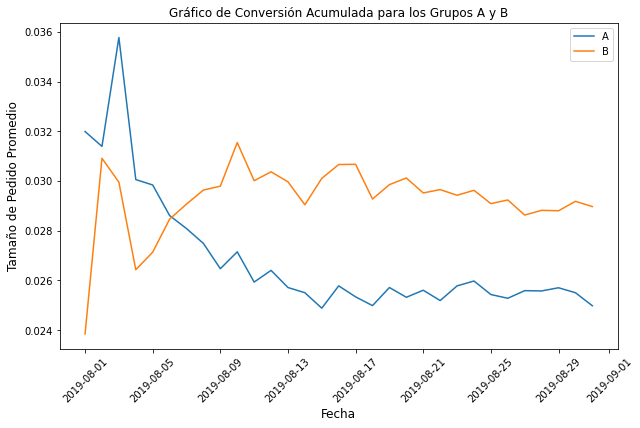

In [68]:
# se ajustan los valores de ancho y alto del gráfico
plt.figure(figsize=(10, 6))

# se trazan los gráficos
plt.plot(cumulativeDataA_['date'], cumulativeDataA_['conversion'], label='A')
plt.plot(cumulativeDataB_['date'], cumulativeDataB_['conversion'], label='B')

plt.legend()

# se rotan las fechas en el eje x a 45 grados
plt.xticks(rotation=45)

# se asigna un nombre
plt.title('Gráfico de Conversión Acumulada para los Grupos A y B')
# se nombran los ejes
plt.xlabel('Fecha', fontsize= 12)
plt.ylabel('Tamaño de Pedido Promedio', fontsize= 12)


plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
En un inicio el grupo A tenía una tasa de conversión mayor que el grupo B, después la tasa de conversión del grupo B aumenta y al final se estabiliza, mientras que en el grupo A comienza a disminuir y para el final parece decrecer aún más. En ambos grupos la tasa de conversión fluctua y se observa que aparentemente el grupo B tiene una mayor tasa de conversión.
    
</span>
    
</div>

### Tasas de conversión diarias de los dos grupos. <a id='conversion_diaria'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Ahora se trazará un gráfico de diferencia relativa para las tasas de conversión acumuladas, se unen los DatFrame `cumulativeDataA` y `cumulativeDataB` utilizando el método `merge()`. 
    
</span>
    
</div>

In [69]:
# se unen los DataFrame, el DataFrame resultante tiene las columnas ['date', 'conversionA', 'conversionB']
# se guarda en mergedCumulativeConversions
mergedCumulativeConversions = cumulativeDataA_[['date','conversion']].merge(cumulativeDataB_[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


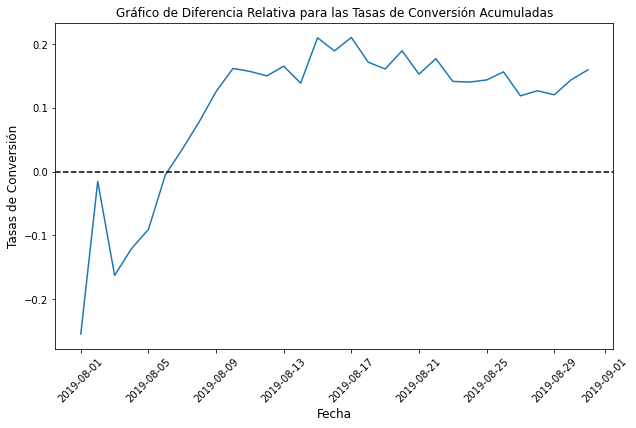

In [70]:
# se ajustan los valores de ancho y alto del gráfico
plt.figure(figsize=(10, 6))

# se traza la diferencia relativa entre la tasa de conversión acumulada del grupo B en comparación con la del grupo A
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

# se rotan las fechas en el eje x a 45 grados
plt.xticks(rotation=45)

# se asigna un nombre
plt.title('Gráfico de Diferencia Relativa para las Tasas de Conversión Acumuladas')
# se nombran los ejes
plt.xlabel('Fecha', fontsize= 12)
plt.ylabel('Tasas de Conversión', fontsize= 12)

plt.axhline(y=0, color='black', linestyle='--')

plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
En un inicio la tasa de conversión del grupo B es menor que el grupo A, posteriormente aumenta y así se mantine, aunque fluctua. No obstante, es mayor de  la tasa de conversión indicando que es más grande en comparación con el grupo A en un 20%. Aunque se hará un análisis de las anomalías que pudieran existir.  
    
</span>
    
</div>

### Valores atípicos y aumentos: valores extremos <a id='atipicos'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Se buscan los datos atípicos, se realiza un gráfico de dispersión y se calculan los percentiles 95 y 99, tanto para el número de pedidos como para los ingresos.  
    
</span>
    
</div>

#### Gráfico de dispersión del número de pedidos por usuario <a id='scatter_orders'></a>

In [71]:
#* se encuentra el número de pedidos por usuario, para hacerlo, se crea un DataFrame con dos columnas:'visitor_id' y 'transaction_id'. 
# el resultado se guarda n ordersByUsers. Ordena los datos por el número de pedidos en orden 
ordersByUsers = (orders_us.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique}))

# se renombran las columnas
ordersByUsers.columns = ['user_id', 'orders']

# se imprimen 10 filas ordenadas de mayor a menor con base en el número de órdenes
ordersByUsers.sort_values(by='orders', ascending= False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


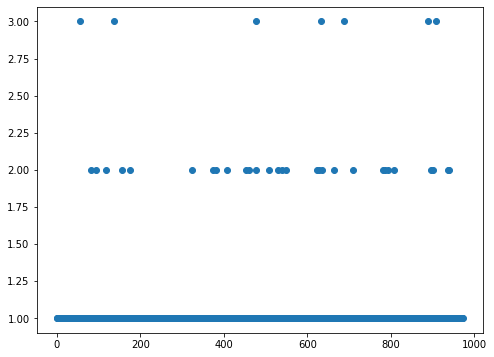

In [72]:
# se traza  un gráfico de dispersión con el número de pedidos por usuario
# se asignan los valores del eje x

# se ajustan los valores de ancho y alto del gráfico
plt.figure(figsize=(8, 6))
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])

plt.show()

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Observaciones:**  
Hay muchos usuarios con 2 y 3 pedidos, por lo tanto se procede a calcular los percentiles 95 y 99 para el número de pedidos por usuario.
    
</span>
    
</div>

In [73]:
# con numpy se calculan los percentiles 95 y 99
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
No más del 5 % de los usuarios/as hicieron más de 1 pedido y no más del 1 % de los/las clientes realizan más de 2 pedidos. Por lo tanto, es razonable establecer 1 pedido por usuario como límite inferior para el número de pedidos y filtrar las anomalías en base a ello. 
    
</span>
    
</div>

#### Gráfico de dispersión de los precios de los pedidos <a id='scatter_price'></a>

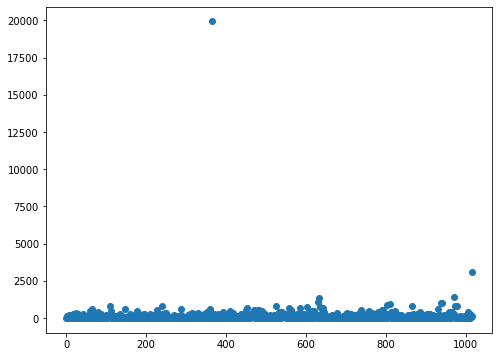

In [74]:
# se crea un gráfico de dispersión utilizando el método scatter()
# se guardan los valores para el eje horizontal x_values_revenue: los números generados de observaciones.
x_values_revenue = pd.Series(range(0, len(orders_us['revenue'])))

# se toman los valores del eje vertical de la columna 'revenue' del DataFrame 'orders_us'
plt.figure(figsize=(8, 6))
plt.scatter(x_values_revenue, orders_us['revenue'])
plt.show()

In [75]:
# con numpy se calculan los percentiles 95 y 99
print(np.percentile(orders_us['revenue'], [95, 99]))

[414.275 830.3  ]


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
No más del 5 % de los usuarios/as hicieron pedidos que costaron más de 414 y no más del 1 % de los/las clientes realizaron pedidos que costaron más de 830. Por lo tanto, es razonable establecer que el costo de los pedidos fue alrededor de 415.
    
</span>
    
</div>

### Significancia estadística de la diferencia en la conversión entre los grupos con los datos en bruto <a id='sig_esta_conversion'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
****  
Se crean las variables `ordersByUsersA` y `ordersByUsersB` para almacenar las columnas ['user_id', 'orders']. Para los usuarios con al menos un pedido, se indica el número de pedidos realizados
    
</span>
    
</div>

In [76]:
# se almacenan los valores para el grupo A
ordersByUsersA = orders_us[orders_us['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']

# se almacenan los valores para el grupo B
ordersByUsersB = orders_us[orders_us['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders']

print('Grupo A')
print(ordersByUsersA.head())
print()
print('Grupo B')
print(ordersByUsersB.head())

Grupo A
    user_id  orders
0  11685486       1
1  54447517       1
2  66685450       1
3  78758296       1
4  85103373       1

Grupo B
    user_id  orders
0   5114589       1
1   6958315       1
2  39475350       1
3  47206413       1
4  48147722       1


In [77]:
# se declara las variables sampleA y sampleB, con los usuarios que realizaron pedidos y los números de 
# pedidos correspondientes. Los usuarios sin pedidos tendrán un 0
# Lo anterior es necesario para preparar las muestras para la prueba de Mann-Whitney

sampleA = pd.concat([ordersByUsersA['orders'], 
                     pd.Series(0, index=np.arange(visits_us[visits_us['group']=='A']['visits'].sum() 
                     - len(ordersByUsersA['orders'])), name='orders')], axis=0
                    )

sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0, index=np.arange(visits_us[visits_us['group']=='B']['visits'].sum() 
                     - len(ordersByUsersB['orders'])), name='orders')],axis=0
                   )

In [78]:
# Se calcula la significancia estadística de la diferencia en la conversión basada en los resultados después 
# Se aplica la prueba de Mann-Whitney
# Se imprime el valor p para comparar la conversión de los grupos 
# se redondea a cinco decimales.
print(f'Valor p: {stats.mannwhitneyu(sampleA, sampleB)[1] :.5f}')

# se calcula e imprime la diferencia relativa en la conversión entre los grupos
print(f'Diferencia relativa en la conversión para el grupo B: {sampleB.mean()/sampleA.mean()-1 :.5f}')

Valor p: 0.01102
Diferencia relativa en la conversión para el grupo B: 0.15980


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
El valor de p es de 0.01102 el cual es menor que 0.05, por lo tanto, se rechaza la hipótesis nula ya que hay una diferencia estadísticamente significativa en la conversión entre los grupos, asimismo, con el valor de p se puede decir que hay una probabilidad del 1.102 % de equivocación al rechazar la hipótesis nula. En cuanto a la diferencia relativa, hay un aumento del 15.9 % para el grupo B.
    
</span>
    
</div>

### Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto <a id='sig_esta_pedidos'></a>

In [80]:
# ahora para calcular la importancia estadística de la diferencia en el tamaño medio de los pedidos de los grupos, 
# pasaremos los datos sobre los ingresos al criterio mannwhitneyu()
p_value = stats.mannwhitneyu(orders_us[orders_us['group']=='A']['revenue'], orders_us[orders_us['group']=='B']['revenue']).pvalue

print(f'Valor p: {round(p_value, 5)}')

# se calcula e imprime la diferencia relativa en el tamaño de los pedidos entre los grupos
print(f"Diferencia relativa en el tamaño promedio para el grupo B: {orders_us[orders_us['group']=='B']['revenue'].mean()/orders_us[orders_us['group']=='A']['revenue'].mean()-1 :3f}")

Valor p: 0.86223
Diferencia relativa en el tamaño promedio para el grupo B: 0.278345


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
EL valor de p es de 0.86223, el cual es mayor que 0.05, por tanto la hipótesis nula no se rechaza. No hay diferencia en el tamaño medio de los grupos. Sin embargo, el tamaño de pedido promedio para el grupo B es mucho más grande que para el grupo A, en un 27.83 %.
    
</span>
    
</div>

### Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. <a id='conversion_filtrado'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  

****
Ahora vamos a eliminar las anomalías de nuestros datos.  
Recodando que los percentiles 95 y 99 para el tamaño promedio de pedido fueron 414 y 830.  
Para el número de pedidos, los percentiles 95 y 99 fueron de 1 y 2 pedidos.  
    
Consideraremos usuarios anómalos a aquellos que realizaron más de 1 pedido o realizaron uno de más de 415. Así, se elimina el 5 % de los usuarios con más pedidos y entre el 1% y el 5% de los pedidos más caros.
    
</span>
    
</div>

In [81]:
# se crean slices de datos con los usuarios que realizaron más de dos pedidos (usersWithManyOrders)
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['user_id'], ordersByUsersB[ordersByUsersB['orders'] > 1]['user_id']], axis = 0)

# y se filtran los usuarios que realizaron pedidos por más de $500 (usersWithExpensiveOrders)
usersWithExpensiveOrders = orders_us[orders_us['revenue'] > 415]['visitor_id']

# se unen los 'usersWithManyOrders' y 'usersWithExpensiveOrders' en una tabla llamada abnormalUsers
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis= 0).drop_duplicates().sort_values()

print(abnormalUsers.head())
print()
print(f'Usuarios anómalos: {abnormalUsers.shape[0]}')

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64

Usuarios anómalos: 86


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  

****
Ahora se calcula la significancia estadística de las diferencias en la conversión entre los grupos con datos filtrados.  
Primero prepararemos muestras del número de pedidos por usuario para cada grupo de prueba.  

    
</span>
    
</div>

In [82]:
# se crean las variables sampleAFiltered y sampleBFiltered para almacenar los datos después de que se hayan eliminado las anomalías.
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['user_id'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visits_us[visits_us['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['user_id'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visits_us[visits_us['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

# se aplica el criterio estadístico de Mann-Whitney a las muestras resultantes
p_value_filtered = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered).pvalue
print(f'Valor p: {round(p_value_filtered, 5)}')
print()
print(f'Diferencia relativa en la conversión para el grupo B: {sampleBFiltered.mean()/sampleAFiltered.mean()-1 :.5f}')



Valor p: 0.01593

Diferencia relativa en la conversión para el grupo B: 0.17393


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
El valor de p de la conversión con los datos filtrados no cambiaron mucho, su valor es de 0.01593, por tanto se rechaza la hipótesis nula. La diferencia relativa es de 17.39 % para el grupo B.  
    
</span>
    
</div>

### Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. <a id='pedidos_filtrado'></a>


In [83]:
# # se aplica el criterio estadístico de Mann-Whitney 
p_value_filtered_orders = stats.mannwhitneyu(orders_us[np.logical_and(orders_us['group']=='A',
                                    np.logical_not(orders_us['visitor_id'].isin(abnormalUsers)))]['revenue'],
                                    orders_us[np.logical_and(orders_us['group']=='B',
                                    np.logical_not(orders_us['visitor_id'].isin(abnormalUsers)))]['revenue']).pvalue

# Diferencia relativa del tamaño de los pedidos
groupA = orders_us[np.logical_and(orders_us['group']=='A', np.logical_not(orders_us['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()
groupB = orders_us[np.logical_and(orders_us['group']=='B',np.logical_not(orders_us['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()

dif_orders_filt = groupB / groupA - 1

print(f'Valor p: {round(p_value_filtered_orders, 5)}')
print()
print(f'Diferencia relativa en el tamaño promedio para el grupo B: {dif_orders_filt :.5f}')

Valor p: 0.77119

Diferencia relativa en el tamaño promedio para el grupo B: -0.03330


<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Conclusiones:**  
El valor de p disminuyó a 0.77119, el cual contnua siendo menor a 0.05, la diferencia entre los grupos disminuyó a -3.33 %. Por lo tanto, No hay diferencia en el tamaño medio del pedido entre los grupos.
    
</span>
    
</div>

## Resumen y Conclusión General <a id='end'></a>

<div style="background-color: lightyellow; padding: 10px;">

<span style="color: darkblue;">  
    
**Resumen General de los pasos seguidos:**  
1. Se descargaron y se lamacenaron los datos y se prepararon para el análisis.
2. Se realizó la priorización de hipótesis con el Framework ICE y RICE.  
3. Se hizo un análisis de Test A/B.  
4. Se representó gráficamente el ingreso acumulado por grupo.  
5. Se representó gráficamente el tamaño de pedido promedio acumulado por grupo.  
6. Se representó gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A.  
7. Se calculó la tasa de conversión diaria para cada grupo y se representó gráficamente las tasas de conversión diarias.  
8. Se hizo un gráfico de dispersión del número de pedidos por usuario.  
9. Se calcularon los percentiles 95 y 99 para el número de pedidos por usuario.  
10. En un gráfico se representó la dispersión de los precios de los pedidos.  
11. Se calcularon los percentiles 95 y 99 de los precios de los pedidos.  
12. Se calculó la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto.  
13. Se encontró la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto.  
14. Cálculo de la significancia estadística de la diferencia en la conversión entre los grupos utilizando datos filtrados.  
15. Cálculo de la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando datos filtrados.  

**Conclusión General:**  
• Hay una diferencia estadísticamente significativa de acuerdo a los datos sin filtrar y los datos filtrados en la conversión de los usuarios/as. El grupo B tiene una conversión más alta, en los datos sin filtrar la diferencia relativa es de 15.9 % y en los datos filtrados de 17.39 %.  

• Ni los datos sin filtrar ni los datos filtrados mostraron diferencias estadísticamente significativas en el tamaño promedio de los pedidos entre los grupos.  

• En el gráfico que muestra la diferencia de conversión entre los grupos se observa que los resultados del grupo B son mejores, en un 20 % más respecto al grupo A en periodo determinado, actualmente es mejor en un 15 % aproximadamente.  

• El gráfico que muestra la diferencia en el tamaño medio de los pedidos entre los grupos nos dice que los resultados del grupo B están fluctuando constantemente, en algunos días tiene picos muy alto y en otros son muy bajos, en los últimos días disminuye. Por lo tanto, de este gráfico no se pueden sacar conclusiones definitivas.  

• Con base en los resultados se recomienda parar la prueba y considerar al grupo B como líder respecto al grupo A, al menos en la conversión de usuarios/as.  
    
</span>
    
</div>